# Introduction :

**In this notebook we will use various machine learnning models in order to evaluate how accurate they are in detecting customer satisfaction in the airline industry. We used the Aireline sentiment analysis from kaggle we've focused on two features:**
*             **airline_sentiment**
*             **Text**


**Our Goals :**

* **Understand the  distribution of the  data that was provided to us.**
* **Create a balanced dataframe of "positive", "neutral" and "negative" comments using EDA (easy data augmentation)  and see the impact of this technique on our models**
* **Determine the Classifiers we are going to use and decide which one has a higher accuracy.**
* **Understand common mistakes made with imbalanced datasets.**

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#importing packages that we need
import numpy as np 
import pandas as pd 
# Data visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# I- Dataset

## 1.1. importing dataset

In [4]:
pd.options.mode.chained_assignment = None  
df = pd.read_csv('data/Tweets.csv',index_col=None)
df=df[['airline_sentiment','text']]
df.head(10)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
5,negative,@VirginAmerica seriously would pay $30 a fligh...
6,positive,"@VirginAmerica yes, nearly every time I fly VX..."
7,neutral,@VirginAmerica Really missed a prime opportuni...
8,positive,"@virginamerica Well, I didn't…but NOW I DO! :-D"
9,positive,"@VirginAmerica it was amazing, and arrived an ..."


## 1.2. exploring dataset

In [5]:
df.shape

(14640, 2)

In [6]:
#different sentiments
sentiments = set(df['airline_sentiment'])
print('Sentiments', sentiments)

Sentiments {'negative', 'positive', 'neutral'}


#### wordcloud

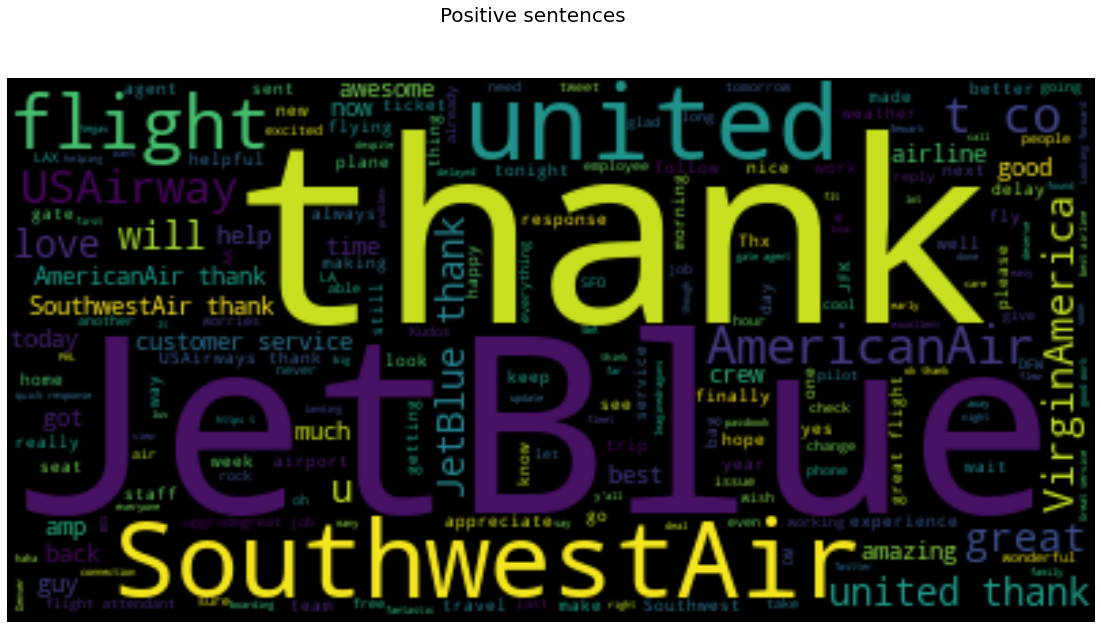

In [8]:
#extraction Positive Keywords
from collections import Counter

def extract_keywords(text,num=50):
    tokens=[tok for tok in text.split()]
    most_commen_tokens=Counter(tokens).most_common(num)
    return dict(most_commen_tokens)
#sentiment list
sentiment_list=df['airline_sentiment'].unique().tolist()
positive_list=df[df['airline_sentiment']=='positive']['text'].tolist()
positive_docx=' '.join(positive_list)
keywords_positive=extract_keywords(positive_docx)
np.array(keywords_positive)


#Word Cloud
from wordcloud import WordCloud
def plot_wordcloud(docx):
    mywordcloud=WordCloud().generate(docx)
    plt.figure(figsize=(20,10))
    plt.imshow(mywordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.suptitle('Positive sentences', fontsize=20)
    
    plt.show()
    
plot_wordcloud(positive_docx) 

In [9]:
#Distribution
print('negative', round(df['airline_sentiment'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('neutral', round(df['airline_sentiment'].value_counts()[1]/len(df) * 100,2), '% of the dataset')
print('positive', round(df['airline_sentiment'].value_counts()[2]/len(df) * 100,2), '% of the dataset')

negative 62.69 % of the dataset
neutral 21.17 % of the dataset
positive 16.14 % of the dataset


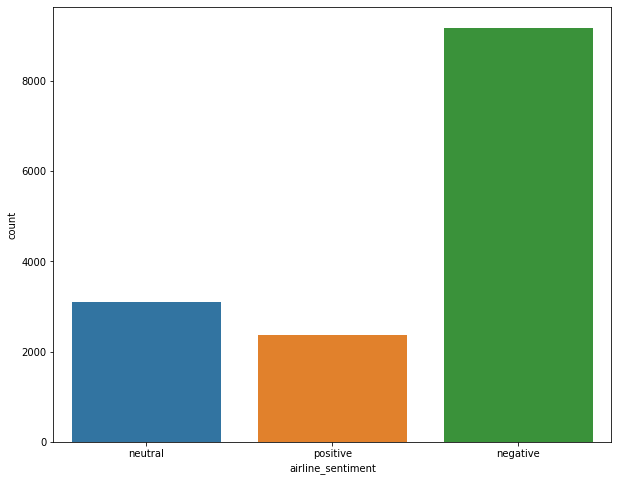

In [10]:
plt.figure(figsize = (10, 8))
sns.countplot(x=df['airline_sentiment'])
plt.show()

**Note:**

**Notice how imbalanced is our original dataset! Most of the comments are negative. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most customers are unsatisfied with the airline services. But we don't want our model to assume, we want our model to detect the correct customer satisfaction.**

# II- Pre-Processing

In [12]:
from textblob import Word 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet 
lemmatizer = WordNetLemmatizer()

In [ ]:
#pip install contractions neattext pyenchant emoji
#pip install nltk
#!pip install contractions neattext pyenchant emoji
#!pip install nltk
#!pip install neattext
#!pip install pyenchant
#!pip install emoji

In [13]:
#!apt -y install enchant --fix-missing

In [15]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\MAROUANE\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [16]:
#we noticed that our data contains insignificant words
import enchant
def check_meaning_words(data,column):
                    d = enchant.Dict("en_US")
                    i=0
                    for sentence in data[column]:
                                l=[]
                                for token in sentence:
                                     if d.check(str(token)):
                                            l+=[token]
                                data[column][i]=l
                                i=i+1 
                    return data[column]    


In [17]:
#convert links to string
import re
def convert_links_to_text(text):
         new = re.sub(r'^https?:\/\/.*[\r\n]*', 'link', text, flags=re.MULTILINE)
         return new

In [18]:
#convert emails to string
def convert_emails_to_text(text):
         new1 = re.sub(r'([A-Za-z0-9]+[.-_])*[A-Za-z0-9]+@[A-Za-z0-9-]+(\.[A-Z|a-z]{2,})+', 'email', text, flags=re.MULTILINE)
         return new1

In [19]:
import emoji
def convert_emojis_to_text(text):
          new=emoji.demojize(text, delimiters=("", "")) 
          return new

In [20]:
def remove_redundant_chars(data,column):
            i=0
            for sentence in data[column]:
                l=[]
                for token in sentence:
                    if 'aa' in token:
                            repeat_pattern = re.compile(r'(\w)\1*')
                            y=repeat_pattern.sub(r'\1',token)
                            #y=re.sub(r"(.)\1\1+", r"\1\1", token)
                    else:
                        y=token
                    l+=[y]
                data[column][i]=l
                i=i+1
            return data[column]    

In [21]:
import contractions
def fix_contractions(data,column):
        i=0
        for sentence in data[column]:
            expanded_words=[]
            for word in sentence:
                        expanded_words+=[contractions.fix(word)]
            data[column][i]=expanded_words
            i=i+1
        return data[column]

In [22]:
import neattext.functions as nfx
import nltk
from nltk.tokenize.treebank import TreebankWordDetokenizer
#     nltk.download('wordnet')
#     nltk.download('punkt')
#     nltk.download('stopwords')

#cleaning fct
def clean_data(data,column):
    #convert text to lower
    data[column]=data[column].str.lower()
    #remove numbers
    data[column]=data[column].apply(nfx.remove_numbers)
    #remove userhandles
    data[column]=data[column].apply(nfx.remove_userhandles)
    #remove punctuations
    data[column]=data[column].apply(nfx.remove_punctuations)
    #remove special characters
    data[column]=data[column].apply(nfx.remove_special_characters)
    #remove hashtags
    data[column]=data[column].apply(nfx.remove_hashtags)
    #remove some words 
    data[column].replace("amp", " ", regex=True, inplace=True)
    #remove multiple space
    data[column]=data[column].apply(nfx.remove_multiple_spaces)
    #lemmatization
    data[column]=data[column].apply(lambda x: " ".join([lemmatizer.lemmatize(word,wordnet.VERB) for word in x.split()]))
    data[column]=data.apply(lambda row: convert_emojis_to_text(row[column]), axis=1)
    data[column]=data.apply(lambda row: convert_links_to_text(row[column]), axis=1)
    data[column]=data.apply(lambda row: convert_emails_to_text(row[column]), axis=1)
    data['tokenized_sents'] = data.apply(lambda row: nltk.word_tokenize(row[column]), axis=1)
    data['tokenized_sents']=check_meaning_words(data,'tokenized_sents')
    data['tokenized_sents']=remove_redundant_chars(data,'tokenized_sents')
    data['tokenized_sents']=fix_contractions(data,'tokenized_sents')
    data['detokenized_sents'] = data.apply(lambda row: TreebankWordDetokenizer().detokenize(row['tokenized_sents']), axis=1)
    data=data[data['detokenized_sents'].str.len()>=4]
    #delete empty rows
    data = data[data['detokenized_sents']!= '']
    #reset data index
    data=data.reset_index().drop('index',axis=1)
    return data

In [23]:
data=clean_data(df,'text')
data.head()

,airline_sentiment,text,tokenized_sents,detokenized_sents
0,neutral,what say,"[what, say]",what say
1,positive,plus youve add commercials to the experience t...,"[plus, add, commercials, to, the, experience, ...",plus add commercials to the experience tacky
2,neutral,i didnt today must mean i need to take another...,"[i, today, must, mean, i, need, to, take, anot...",i today must mean i need to take another trip
3,negative,its really aggressive to blast obnoxious enter...,"[its, really, aggressive, to, blast, obnoxious...",its really aggressive to blast obnoxious enter...
4,negative,and its a really big bad thing about it,"[and, its, a, really, big, bad, thing, about, it]",and its a really big bad thing about it


## Split Data

In [24]:
from sklearn.model_selection import train_test_split
X=data['detokenized_sents']
y=data['airline_sentiment']
#we used  80% for training data and 20% for testing
train,valid=train_test_split(data[['detokenized_sents','airline_sentiment']],test_size=0.2, random_state=42)

print(len(train))
print(len(valid))

11665
2917


# III- Easy Data Augmentation EDA

**Easy data augmentation refers to a set of technics used for boosting text classification tasks:**

1. **SR : Synonym Replacement**
2. **RD : Random Deletion**
3. **RS : Random Swap**
4. **RI : Random Insertion**

**Note** : It's recommended to apply EDA on the training subset and not the whole dataset. A validation subset from the original dataset is set aside for evaluating the model's performance at the end.

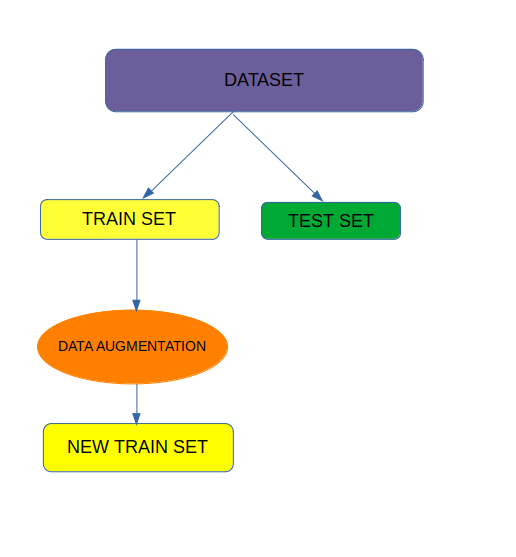

## 3.1.  Synonyme replacement (SR)

Synonym replacement is a technique in which we replace a word by one of its synonyms For identifying relevent Synonyms we use WordNet.

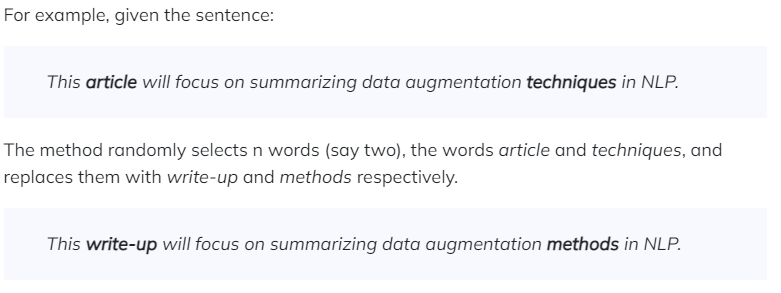

In [25]:
#We define the get_synonyms function to retrieve pre-processed list of synonyms of a given word
from nltk.corpus import wordnet
def get_synonyms(word):
    
    synonyms = set()
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)

In [26]:
from nltk.corpus import stopwords
stop_words = []
for w in stopwords.words('english'):
    stop_words.append(w)
print(list(stop_words))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [27]:
import random
def synonym_replacement(words, n):
    
    words = words.split()
    
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        
        if num_replaced >= n: #only replace up to n words
            break

    sentence = ' '.join(new_words)

    return sentence

**Note** : you can play around with the n parameter in synonym_replacement to get new sentences in each iteration.

In [28]:
aug_syn = {'airline_sentiment':[],'detokenized_sents':[]}
columns = ['airline_sentiment','detokenized_sents']
for i in train.index:
    if train['airline_sentiment'][i]== 'positive' or train['airline_sentiment'][i]== 'neutral':
        new_row=synonym_replacement(train['detokenized_sents'][i],2)
        aug_syn['airline_sentiment'].append(train['airline_sentiment'][i])
        aug_syn['detokenized_sents'].append(new_row)
        
data1 = pd.DataFrame(aug_syn, columns=columns, index=None)
df = train.append(data1,ignore_index=True)
df

,detokenized_sents,airline_sentiment
0,how is life the,neutral
1,have now have different departure time make up...,negative
2,the dinner and call me hon not the service i w...,neutral
3,my father love work for you as well as,positive
4,i book via however at gate they me to a late f...,negative
...,...,...
16026,when be adjacent lax flight nowadays,neutral
16027,not though,neutral
16028,thank for the dislodge birthday gunpoint be al...,positive
16029,i make it head to and your employee really be ...,positive


## 3.2. Random Deletion (RD)

In Random Deletion, we randomly delete a word if a uniformly generated number between 0 and 1 is smaller than a pre-defined threshold. This allows for a random deletion of some words of the sentence.

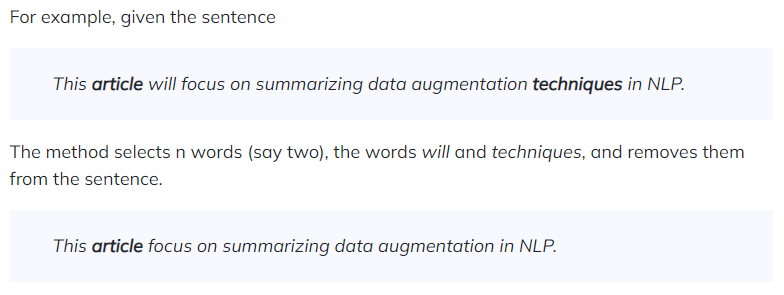

In [29]:
def random_deletion(words, p):
    words = words.split()
    #obviously, if there's only one word, don't delete it
    if len(words) == 1:
        return words

    #randomly delete words with probability p
    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)

    #if you end up deleting all words, just return a random word
    if len(new_words) == 0:
        rand_int = random.randint(0, len(words)-1)
        return [words[rand_int]]

    sentence = ' '.join(new_words)
    
    return sentence

In [30]:
aug_syn = {'airline_sentiment':[],'detokenized_sents':[]}
columns = ['airline_sentiment','detokenized_sents']
for i in df.index:
    if df['airline_sentiment'][i]== 'positive' or df['airline_sentiment'][i]== 'neutral':
        new_row=random_deletion(df['detokenized_sents'][i],0.2)
        aug_syn['airline_sentiment'].append(df['airline_sentiment'][i])
        aug_syn['detokenized_sents'].append(new_row)
        
data2 = pd.DataFrame(aug_syn, columns=columns, index=None)
df1 = df.append(data2,ignore_index=True)
df1

,detokenized_sents,airline_sentiment
0,how is life the,neutral
1,have now have different departure time make up...,negative
2,the dinner and call me hon not the service i w...,neutral
3,my father love work for you as well as,positive
4,i book via however at gate they me to a late f...,negative
...,...,...
24758,when be adjacent lax flight nowadays,neutral
24759,not,neutral
24760,for dislodge birthday all with me,positive
24761,i make it to and your employee really as as i ...,positive


## 3.3.  Random Swap (RS)

In Random Swap, we randomly swap the order of two words in a sentence.

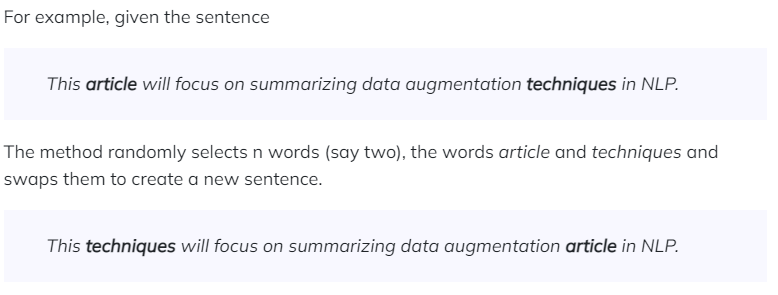

In [31]:
# This will Swap the words
def swap_word(new_words):
    
    random_idx_1 = random.randint(0, len(new_words)-1)
    random_idx_2 = random_idx_1
    counter = 0
    
    while random_idx_2 == random_idx_1:
        random_idx_2 = random.randint(0, len(new_words)-1)
        counter += 1
        
        if counter > 3:
            return new_words
    
    new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1] 
    return new_words

def random_swap(words, n):
    
    words = words.split()
    new_words = words.copy()
    # n is the number of words to be swapped
    for _ in range(n):
        new_words = swap_word(new_words)
        
    sentence = ' '.join(new_words)
    
    return sentence

In [32]:
aug_syn = {'airline_sentiment':[],'detokenized_sents':[]}
columns = ['airline_sentiment','detokenized_sents']
for i in range(3000):
    if df1['airline_sentiment'][i]== 'positive' or df1['airline_sentiment'][i]== 'negative':
        new_row=random_swap(df1['detokenized_sents'][i], 1)
        aug_syn['airline_sentiment'].append(df1['airline_sentiment'][i])
        aug_syn['detokenized_sents'].append(new_row)
        
data3 = pd.DataFrame(aug_syn, columns=columns, index=None)
df2 = df1.append(data3,ignore_index=True)
df2

,detokenized_sents,airline_sentiment
0,how is life the,neutral
1,have now have different departure time make up...,negative
2,the dinner and call me hon not the service i w...,neutral
3,my father love work for you as well as,positive
4,i book via however at gate they me to a late f...,negative
...,...,...
27122,bag just deliver first items have be steal at ...,negative
27123,every time i look at the flight status more mi...,negative
27124,be at at pm still here at be due to mechanical...,negative
27125,all take care call other then the drop of and ...,negative


## 3.4. Random Insertion (RI)

Finally, in Random Insertion, we randomly insert synonyms of a word at a random position.

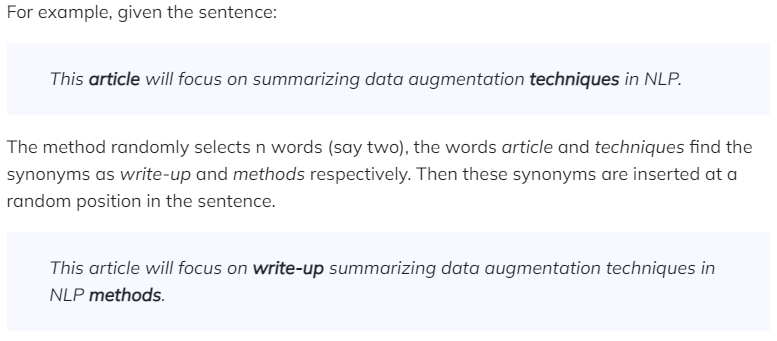

Data augmentation operations should not change the true label of a sentence, as that would introduce unnecessary noise into the data. Inserting a synonym of a word in a sentence, opposed to a random word, is more likely to be relevant to the context and retain the original label of the sentence.

In [33]:
def random_insertion(words, n):
    
    words = words.split()
    new_words = words.copy()
    
    for _ in range(n):
        add_word(new_words)
        
    sentence = ' '.join(new_words)
    return sentence

def add_word(new_words):
    
    synonyms = []
    counter = 0
    
    while len(synonyms) < 1:
        random_word = new_words[random.randint(0, len(new_words)-1)]
        synonyms = get_synonyms(random_word)
        counter += 1
        if counter >= 10:
            return
        
    random_synonym = synonyms[0]
    random_idx = random.randint(0, len(new_words)-1)
    new_words.insert(random_idx, random_synonym)

In [34]:
aug_syn = {'airline_sentiment':[],'detokenized_sents':[]}
columns = ['airline_sentiment','detokenized_sents']

for i in range(2000):
    if df2['airline_sentiment'][i]== 'positive' :
        new_row=random_insertion(df2['detokenized_sents'][i], 1)
        aug_syn['airline_sentiment'].append(df2['airline_sentiment'][i])
        aug_syn['detokenized_sents'].append(new_row)
        
data4 = pd.DataFrame(aug_syn, columns=columns, index=None)
df3 = df2.append(data4,ignore_index=True)
df3

,detokenized_sents,airline_sentiment
0,how is life the,neutral
1,have now have different departure time make up...,negative
2,the dinner and call me hon not the service i w...,neutral
3,my father love work for you as well as,positive
4,i book via however at gate they me to a late f...,negative
...,...,...
27440,from to this morning all of the staff that hel...,positive
27441,connection make thank again connective this week,positive
27442,i know that bar wish i be at that place there now,positive
27443,thank to the gent on the phone who fix my flyi...,positive


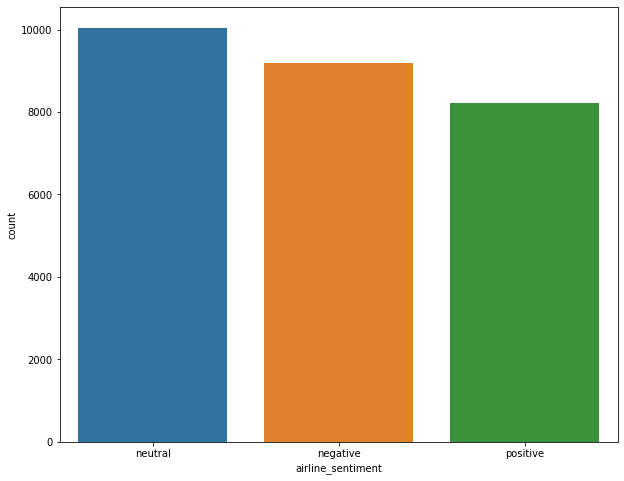

In [35]:
#we can see that our data is balanced
plt.figure(figsize = (10, 8))
sns.countplot(x=df3['airline_sentiment'])
plt.show()

to study the influence of easy data augmentation, we will implement machine learning algorithms on our dataset before and after applying EDA:

# IV- Modeling using training set without EDA

## 4.1. The word embedding technique: TF-IDF

TF-IDF is a statistical measure used to determine the mathematical significance of words in documents. The vectorization process is similar to One Hot Encoding. Alternatively, the value corresponding to the word is assigned a TF-IDF value instead of 1. The TF-IDF value is obtained by multiplying the TF and IDF values.

In [36]:
#NGrams
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
tokenizer = TweetTokenizer()
vectorizer = TfidfVectorizer(ngram_range=(1, 2), tokenizer=tokenizer.tokenize)#it will takes uni_grams,bigrams(max)
vectorizer.fit(list(train['detokenized_sents'].values))
X_train=train['detokenized_sents']
X_test=valid['detokenized_sents']
y_train=train['airline_sentiment']
y_test=valid['airline_sentiment']
train_vectorized = vectorizer.transform(X_train)
test_vectorized = vectorizer.transform(X_test)

In [37]:
#getFreatures
ngramFeatures = vectorizer.get_feature_names()
np.array(ngramFeatures)

array(['a', 'a a', 'a able', ..., 'zone your', 'zoom', 'zoom in'],
      dtype='<U29')

## 4.2-Implementing machine learning algorithms:

**Note**: we decided to use two binary classification algorithms: Logistic Regression and SVM,  to see their function on multiclass problems.

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,confusion_matrix

### 4.2.1. Logistic Regression

In [39]:
lr = LogisticRegression()
lr.fit(train_vectorized,y_train)
print(confusion_matrix(lr.predict(test_vectorized ) , y_test))
print()
print(classification_report( lr.predict(test_vectorized ) , y_test))
print("accuracy: ",accuracy_score( lr.predict(test_vectorized ) , y_test ))

[[1805  280  165]
 [  50  248   50]
 [  15   24  280]]

              precision    recall  f1-score   support

    negative       0.97      0.80      0.88      2250
     neutral       0.45      0.71      0.55       348
    positive       0.57      0.88      0.69       319

    accuracy                           0.80      2917
   macro avg       0.66      0.80      0.71      2917
weighted avg       0.86      0.80      0.82      2917

accuracy:  0.7997943092218032


### 4.2.2. Support Vector Machine (SVM)

In [40]:
from nltk import probability
svm = SVC(probability=True)
svm.fit(train_vectorized,y_train)
print(classification_report(svm.predict(test_vectorized) , y_test))
print("accuracy: ",accuracy_score( svm.predict(test_vectorized) , y_test ))

              precision    recall  f1-score   support

    negative       0.97      0.78      0.87      2323
     neutral       0.37      0.73      0.49       281
    positive       0.55      0.87      0.67       313

    accuracy                           0.79      2917
   macro avg       0.63      0.79      0.68      2917
weighted avg       0.87      0.79      0.81      2917

accuracy:  0.7857387727116901


### 4.2.3. Voting Classifier

In [41]:
#combination svm and LR
estimators = [ ('svm',svm) , ('lr' , lr) ]
clf = VotingClassifier(estimators , voting='soft')
clf.fit(train_vectorized,y_train)
print(classification_report( clf.predict(test_vectorized) , y_test))
print("accuracy: ",accuracy_score( clf.predict(test_vectorized) , y_test ))

              precision    recall  f1-score   support

    negative       0.94      0.84      0.88      2092
     neutral       0.52      0.67      0.59       427
    positive       0.65      0.81      0.72       398

    accuracy                           0.81      2917
   macro avg       0.70      0.77      0.73      2917
weighted avg       0.84      0.81      0.82      2917

accuracy:  0.8097360301679808


# V- Modeling using training set with EDA

## 5.1. The word embedding technique: TF-IDF

In [42]:
#split data into training and validation set
X=df3['detokenized_sents']
Y=df3['airline_sentiment']
X_train1, X_test1, y_train1, y_test1=train_test_split(X,Y,test_size=0.2, random_state=42)

In [43]:
tokenizer1 = TweetTokenizer()
vectorizer1 = TfidfVectorizer(ngram_range=(1, 2), tokenizer=tokenizer1.tokenize)
X_train2=["".join(review) for review in X_train1.values]
vectorizer1.fit(X_train2)
X_test2=["".join(review) for review in X_test1.values]
vectorizer1.fit(X_test2)
#vectorization
train_vectorized1 = vectorizer1.transform(X_train2)
test_vectorized1 = vectorizer1.transform(X_test2)

## 5.2. Implementing machine learning algorithms:

### 5.2.1. Logistic Regression

In [44]:
lr = LogisticRegression()
lr.fit(train_vectorized1,y_train1)
print(confusion_matrix(lr.predict(test_vectorized1 ) , y_test1))
print()
print(classification_report( lr.predict(test_vectorized1 ) , y_test1))
print("accuracy: ",accuracy_score( lr.predict(test_vectorized1 ) , y_test1 ))

[[1436   53   24]
 [ 328 1911  174]
 [  66   73 1424]]

              precision    recall  f1-score   support

    negative       0.78      0.95      0.86      1513
     neutral       0.94      0.79      0.86      2413
    positive       0.88      0.91      0.89      1563

    accuracy                           0.87      5489
   macro avg       0.87      0.88      0.87      5489
weighted avg       0.88      0.87      0.87      5489

accuracy:  0.8691929313171798


### 5.2.2. Support Vector Machine (SVM)

In [45]:
svm = SVC(probability=True)
svm.fit(train_vectorized1,y_train1)
print(classification_report(svm.predict(test_vectorized1) , y_test1))
print("accuracy: ",accuracy_score( svm.predict(test_vectorized1 ) , y_test1 ))

              precision    recall  f1-score   support

    negative       0.84      0.98      0.90      1574
     neutral       0.97      0.85      0.91      2323
    positive       0.93      0.95      0.94      1592

    accuracy                           0.92      5489
   macro avg       0.91      0.93      0.92      5489
weighted avg       0.92      0.92      0.92      5489

accuracy:  0.9152851156859173


### 5.2.3. Voting Classifier

In [46]:
#combination svm and LR
estimators = [ ('svm',svm) , ('lr' , lr) ]
clf = VotingClassifier(estimators , voting='soft')
clf.fit(train_vectorized1,y_train1)
print(classification_report( clf.predict(test_vectorized1) , y_test1))
print("accuracy: ",accuracy_score( clf.predict(test_vectorized1) , y_test1 ))

              precision    recall  f1-score   support

    negative       0.86      0.97      0.91      1629
     neutral       0.96      0.86      0.91      2256
    positive       0.93      0.94      0.94      1604

    accuracy                           0.92      5489
   macro avg       0.92      0.92      0.92      5489
weighted avg       0.92      0.92      0.92      5489

accuracy:  0.9172891237019494


**Note:  we can see that the accuracy of our models has improved after using the EDA technique**

# VI- Best model selection using ROC-AUC curve

In [47]:
# Import label encoder
from sklearn import preprocessing
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
# Encode labels
y_test2= label_encoder.fit_transform(y_test1)

def roc_auc_curve():
    pred_prob1 = lr.predict_proba(test_vectorized1) #Logistic regression
    pred_prob2 = svm.predict_proba(test_vectorized1)#svm
    pred_prob3 = clf.predict_proba(test_vectorized1)#voting classifier

    #for the positive class
    # roc curve for models
    fpr1, tpr1, _ = roc_curve(y_test2, pred_prob1[:,1], pos_label=1)
    fpr2, tpr2, _ = roc_curve(y_test2, pred_prob2[:,1], pos_label=1)
    fpr3, tpr3, _ = roc_curve(y_test2, pred_prob3[:,1], pos_label=1)

    # roc curve for tpr = fpr
    random_probs = [0 for i in range(len(y_test2))]
    p_fpr, p_tpr, _ = roc_curve(y_test2, random_probs, pos_label=1)
    # auc scores
    auc_score1 = roc_auc_score(y_test2, pred_prob1,multi_class='ovr')# logistic regression
    auc_score2 = roc_auc_score(y_test2, pred_prob2,multi_class='ovr')# svm
    auc_score3 = roc_auc_score(y_test2, pred_prob3,multi_class='ovr')# voting classifier


    plt.style.use('seaborn')
    # plot roc curves
    plt.plot(fpr1, tpr1, linestyle='--',color='orange',label="Logistic Regression: AUC="+str(auc_score1))
    plt.plot(fpr2, tpr2, linestyle='--',color='green', label='SVM: AUC='+str(auc_score2))
    plt.plot(fpr3, tpr3, linestyle='--',color='red', label='Voting Classifier : AUC='+str(auc_score3))


    # plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
    plt.plot([0, 1], [0, 1],'r--')

    # title
    plt.title('ROC curve: ')
    # x label
    plt.xlabel('False Positive Rate')
    # y label
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.savefig('ROC',dpi=300)
    plt.show(); 

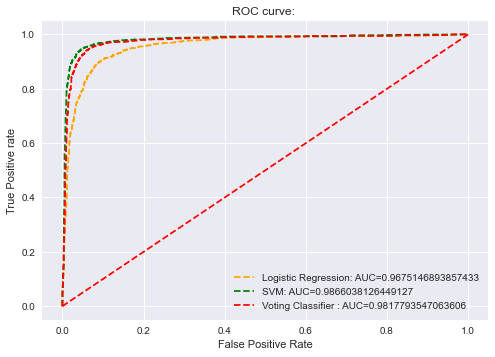

In [48]:
roc_auc_curve()

**Note : we can see that svm is the best model in our case.**

# VII- Test More data

## 7.1. Using validation subset

To know how well does our model preform, we test it on a subset of data that it has never seen to confirm the results we got on training and testing phases since it provides an unbiased final model performance metric in terms of accuracy, precision..etc

In [49]:
#vectorize the text
test =vectorizer1.transform(valid['detokenized_sents'])
            
print(classification_report( svm.predict(test) , valid['airline_sentiment']))
print("accuracy: ",accuracy_score( svm.predict(test) , valid['airline_sentiment']))

              precision    recall  f1-score   support

    negative       0.87      0.89      0.88      1826
     neutral       0.67      0.56      0.61       664
    positive       0.66      0.76      0.71       427

    accuracy                           0.79      2917
   macro avg       0.73      0.74      0.73      2917
weighted avg       0.79      0.79      0.79      2917

accuracy:  0.7939664038395612


we can see that our model can generalize and make accurate classifications on the data it has not seen before.

## 7.2. using new phrases

In [50]:
#create a function  that takes a text as input and return the suitable sentiment 
def detect_sentment(text):
            #vectorize the text
            test = vectorizer1.transform([text])
            l=svm.predict(test)
            #Check for the prediction probability
            pred_proba=svm.predict_proba(test)
            pred_percentage_for_all=dict(zip(svm.classes_,pred_proba[0]))
            print("Prediction using SVM:  : {} , Prediction Score : {}".format(l[0],np.max(pred_proba)))
            print()
            print(pred_percentage_for_all)

In [51]:
detect_sentment("it's good to see you!")

Prediction using SVM:  : positive , Prediction Score : 0.9834262947538127

{'negative': 0.00017441560609491455, 'neutral': 0.016399289640092542, 'positive': 0.9834262947538127}


In [52]:
detect_sentment("i'm not satisfied")

Prediction using SVM:  : neutral , Prediction Score : 0.9883119727214615

{'negative': 0.007984698712587422, 'neutral': 0.9883119727214615, 'positive': 0.0037033285659511584}


In [53]:
detect_sentment("i took a flight today!")

Prediction using SVM:  : neutral , Prediction Score : 0.5386160640593927

{'negative': 0.3451788433961338, 'neutral': 0.5386160640593927, 'positive': 0.11620509254447374}


# VIII- Error Analysis

In [54]:
def plotTopErrors(y_predict, top=5):
    ys = y_test.values
    Xs = X_test.values
    errorCount = 0
    
    for i in range(len(ys)):
        if not ys[i]==y_predict[i]:
            errorCount += 1
            print("#{}: Expected: {}, Predicted: {}".format(errorCount, ys[i], y_predict[i]))
            print("Text:", Xs[i])
            print("=================================================")
        if errorCount >= top:
            break

analyse errors of our final model

In [55]:
plotTopErrors(svm.predict(test_vectorized1), top=10)

#1: Expected: negative, Predicted: neutral
Text: not to mention the fact that we pay extra just to fly think it be the most reliable
#2: Expected: negative, Predicted: neutral
Text: its fine just wonder where my money go
#3: Expected: negative, Predicted: neutral
Text: who compensate be for the delay because by the fact that you have enough flight attendants
#4: Expected: negative, Predicted: neutral
Text: sure but the plane be an hour late flight your departure ship sail away a long time back
#5: Expected: negative, Predicted: positive
Text: no other what should be valid circle pacific itineraries can be book either always make all us invalid last leg
#6: Expected: negative, Predicted: neutral
Text: my wife sick and i have be wait in line now for hrs to see an agent phone agent say nothing til
#7: Expected: positive, Predicted: neutral
Text: love southwest you guy have be good to me
#8: Expected: negative, Predicted: neutral
Text: minutes and move two feet in
#9: Expected: negative, P

In [56]:
# create an iterator object with write permission - model.pkl
import pickle

with open('model_pkl_svm', 'wb') as files:
    pickle.dump(svm, files)
    
with open('model_pkl_clf', 'wb') as files:
    pickle.dump(clf, files)

with open('vectorizer', 'wb') as files:
    pickle.dump(vectorizer1, files)

In [57]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Thank you !